In [93]:
library(sensitivity)
library(tidyr)
library(ecotoxicology)
source("augmented_utils.R")

parallel = TRUE
registerDoParallel(cores = 5)

In [3]:
options(repr.plot.width = 10, repr.plot.height = 6)


### CtoR function to associate the best representatives to a given clustering

In [4]:
vec = seq(10^-10,1-10^-10,l=5000) #just a vector to estimate integral

try_unif_1d = function(samp, delta = NULL){ #this compute the optimal parameters of the 1D uniform
  quantiles_vec = quantile(samp, vec) #computation of the empirical quantile function on [0,1]
  if(is.null(delta)){ #if the width of the support is free
    u_bound = mean(quantiles_vec*(6*vec-2)) #estimate upper bound
    l_bound = mean(quantiles_vec*(-6*vec+4)) #estimate lower bound
  }
  else{ #if width of support is given
    l_bound = mean(quantiles_vec-delta/2) #estimate lower bound
    u_bound = l_bound+delta #estimate upper bound
  }
  return(matrix(c(l_bound, u_bound)))
  
}

CtoR = function(clusts, only_bornes = TRUE, n_sample = 500, return_error = FALSE){ #function that associate the best representative, either a dirac or a uniform on each marginal
  rep = list()
  law = list()
  local_errors = c() 
  for(j in 1:length(clusts)){ #for each cluster, the optimal representative will be provided
    mat = NULL
    law_j = c()
    diss_tot = 0 #quantization error
    for(k in 1:ncol(clusts[[j]])){ #for each marginal
      diss_unif = 10^5
      for(delta in c(1/4,1/2,3/4,1)){ #try the support width 0.25,0.5,0.75 and 1
       unif_prov = try_unif_1d(clusts[[j]][,k], delta = delta) #get the uniform with given width
       unif_tilde_prov = from_law_to_sample(list(unif_prov), law = list("unif"), n = n_sample)[[1]] #get sample associated with this uniform
       diss_unif_prov = wasserstein1d(unif_tilde_prov, clusts[[j]][,k],p=2) #compute wasserstein distance between the marginal and the uniform
       if(diss_unif_prov < diss_unif){ #if this uniform is the best, save it
         unif = unif_prov
         unif_tilde = unif_tilde_prov
         diss_unif = diss_unif_prov
       }
      }
     dirac = mean(clusts[[j]][,k]) #try dirac representative
     dirac = matrix(c(dirac, dirac)) 
     dirac_tilde = from_law_to_sample(list(dirac), law = list("dirac"), n = n_sample)[[1]]
     diss_dirac = wasserstein1d(dirac_tilde, clusts[[j]][,k],p=2) #compute wasserstein distance between the marginal and the dirac
     if(diss_dirac > diss_unif){ #if the dirac is not the best representative, keep uniform
      if(!only_bornes){mat = cbind(mat, unif_tilde)} #only_bornes=TRUE indicates that the only the parameters of the representatives are returned. If false, then a sample is returned for the representative
       else{mat = cbind(mat, unif)}
       law_j = c(law_j, "unif")
       diss_tot = diss_tot + diss_unif^2
     }
     else{ #if dirac is the best representative, save it
       if(!only_bornes){mat = cbind(mat, dirac_tilde)}
       else{mat = cbind(mat, dirac)}
       law_j = c(law_j, "dirac")
       diss_tot = diss_tot + diss_dirac^2
     }
    }
    rep[[j]] = mat
    law[[j]] = law_j
    local_errors = c(local_errors, sqrt(diss_tot))
  }
  res = list(rep, law)
  if(return_error){res = c(res,  list(local_errors, sapply(clusts, nrow)))}
  return(res)
}


### Function to initialize the AQ algorithm 

In [ ]:

initialize_algo = function(l,d, multistart = 1){ #function to propose initial mixture (randomly selected)
    starts = list()
    for(start in 1:multistart){ #multistart
        weights = rep(1/l, l = l) #equal weights
        all_law = list()
        all_rep = list()
        for(xx in 1:l){
            size_unif = sample(x= c(0,0.25,0.5, 0.75,1), size = d) #select size of uniform (0 is dirac)
            repres = runif(n = d, min = 0, max = 1-size_unif) #lower bound of the uniform
            repres = rbind(repres, repres + size_unif) #upper bound
            law = rep("dirac", d) 
            law[which(size_unif >0.001)] = "unif"
            all_rep[[xx]] = repres 
            all_law[[xx]] = law
        }
    starts[[start]] = list(rep = all_rep, law = all_law) 
    }
    return(starts)
}

### Ishigmi function and computation of quantile

In [5]:

ishigami <- function(X, a = 4, b = 0.2){
  x1 <- X[, 1]
  x2 <- X[, 2]
  x3 <- X[, 3]
  
  sin(x1) + a * sin(x2)^2 + b * x3^3 * sin(x1)
}

quant = 0.95

sob = sobol(10^7, dim = 3)*2*pi -pi
yy = ishigami(sob)
q_095 <- round(as.numeric(quantile(yy, 0.95)), 2)
q_095



[1] 5.63

### Get conditionnal samples $F_1(X1), F_2(X2), F_3(X3) \mid Y > q_{95}$

[1] 290   3

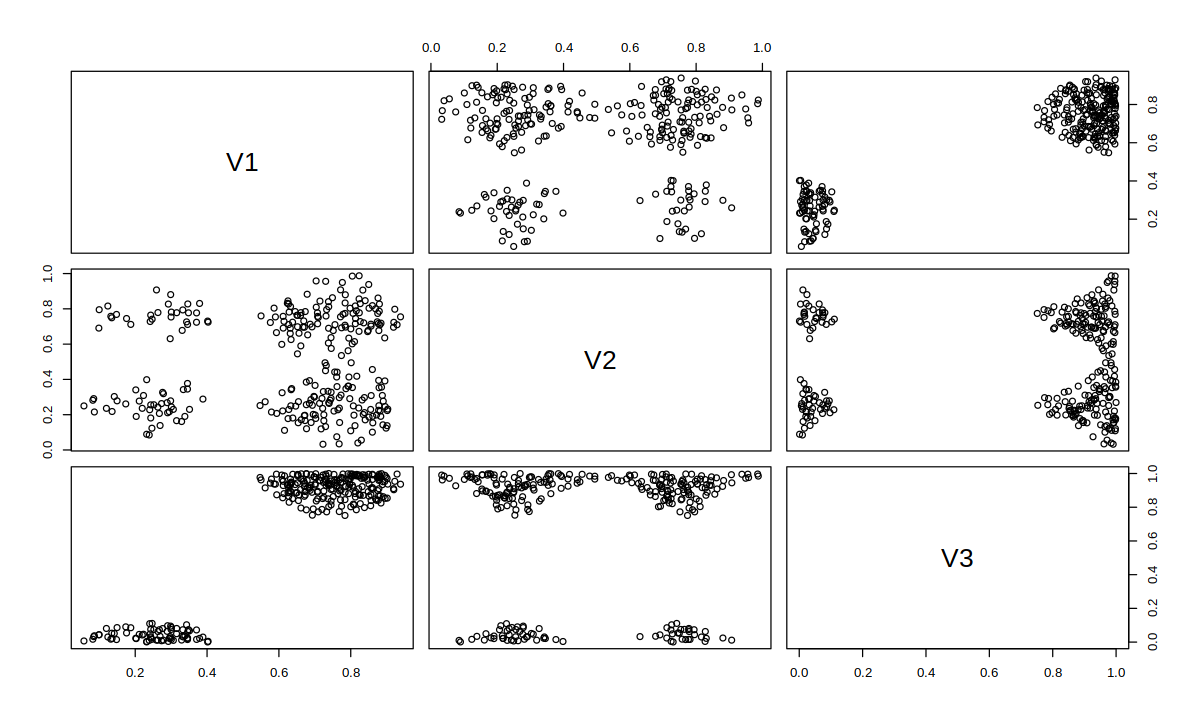

In [11]:
set.seed(10)
X = as.data.frame(matrix(runif(n=6000*3, min = -pi, max = pi), ncol = 3))
yy = ishigami(X)

Xseuil = X[yy>q_095,]
Xsample = apply(Xseuil,2, function(x){(x+pi)/2/pi})
dim(Xsample)
pairs(Xsample)


### Run AQ algorithm

In [ ]:
set.seed(123)
init = initialize_algo(l = 3, d = 3)[[1]]
res_sensi = augmented_quanti(samp = Xsample, rep = init$rep,vec_prop = c(0.4,0.2,0.1), it_lim = 10,n_sample = 1000,threshold = 0.006, law = init$law, prop_search = 1)
save(res_sensi, file = "res_ishi.RData")

### Plot obtained mixture

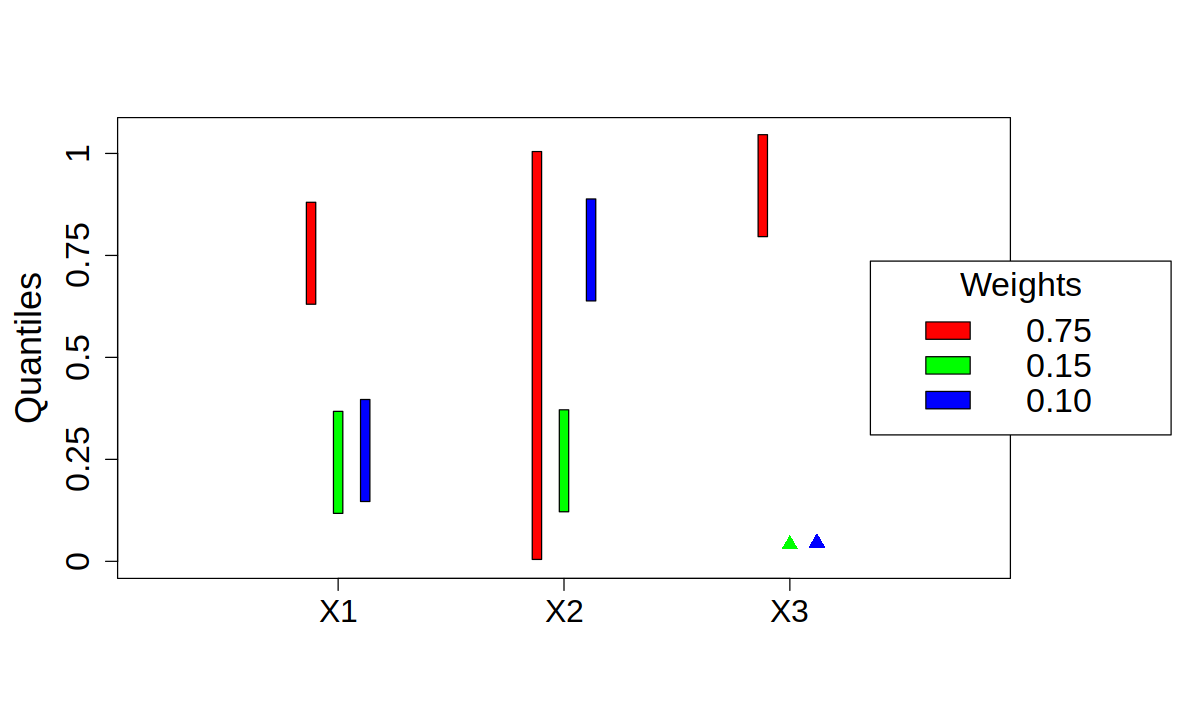

In [94]:
load("res_ishi.RData")
best_sensi = find_best(res_sensi)
df_plot = create_df_plot(best_sensi[[2]], best_sensi[[1]])
plot_hybrid_distrib(df_plot,c("X1","X2","X3"), cex_legend = 1.7, ysize = 1.7)

### Function to compute HSIC indices with ANOVA-like decomposition

In [ ]:
pairs = t(combn(1:3, 2))
func_hsic = function(it){  #we will do it multiples times to obtained boxplots
    X = as.data.frame(matrix(runif(n=6000*3, min = 0, max = 1), ncol = 3)) #Get samples
    outputs = ishigami(X*2*pi-pi) #compute the outputs
    res_hsic = sensiHSIC(model = function(X){return(outputs)}, X = X, target=list(c=q_095, type = "exp1side"), anova = list("obj" = "both"), kernelX = "rbf_anova", kernelY = "rbf_anova") #get hsic indices with all variables
    res = as.numeric(res_hsic$FO[[1]]) #get first order indices
    denom = as.numeric(res_hsic$denom) #get the denominator to normalize the 2nd-order index that will be computed
    for(ii in 1:nrow(pairs)){ #for each pair of variables
        XX = X[,pairs[ii,]] 
        res_hsic = sensiHSIC(model = function(X){return(outputs)}, X = XX, target=list(c=q_095, type = "exp1side"), anova = list("obj" = "both"),kernelX = "rbf_anova", kernelY = "rbf_anova") #get hsic indices considering only these two variables
        interaction = (as.numeric(res_hsic$TO[[1]])[1] - as.numeric(res_hsic$FO[[1]])[1])*as.numeric(res_hsic$denom)/denom #get the 2nd order index and normalize it
        res = c(res, interaction)
    }
    return(res)
}

### Compute the HSIC indices 

In [6]:
set.seed(10)

st =Sys.time()
n_iter = 200
results <- foreach(it = 1:n_iter, .combine = "rbind") %dopar% {
  func_hsic(it)
}
print(Sys.time()-st) 
results = as.data.frame(results)
colnames(results) = c("X1","X2","X3","X1X2","X1X3","X2X3")
results["X1X2X3"] = 1-apply(results, 1, sum)
write.csv(results, file = "results_hsic_ishigami_interactions.csv", row.names = FALSE)

Time difference of 1.460804 hours


### Plot the distributions of the HSIC indices

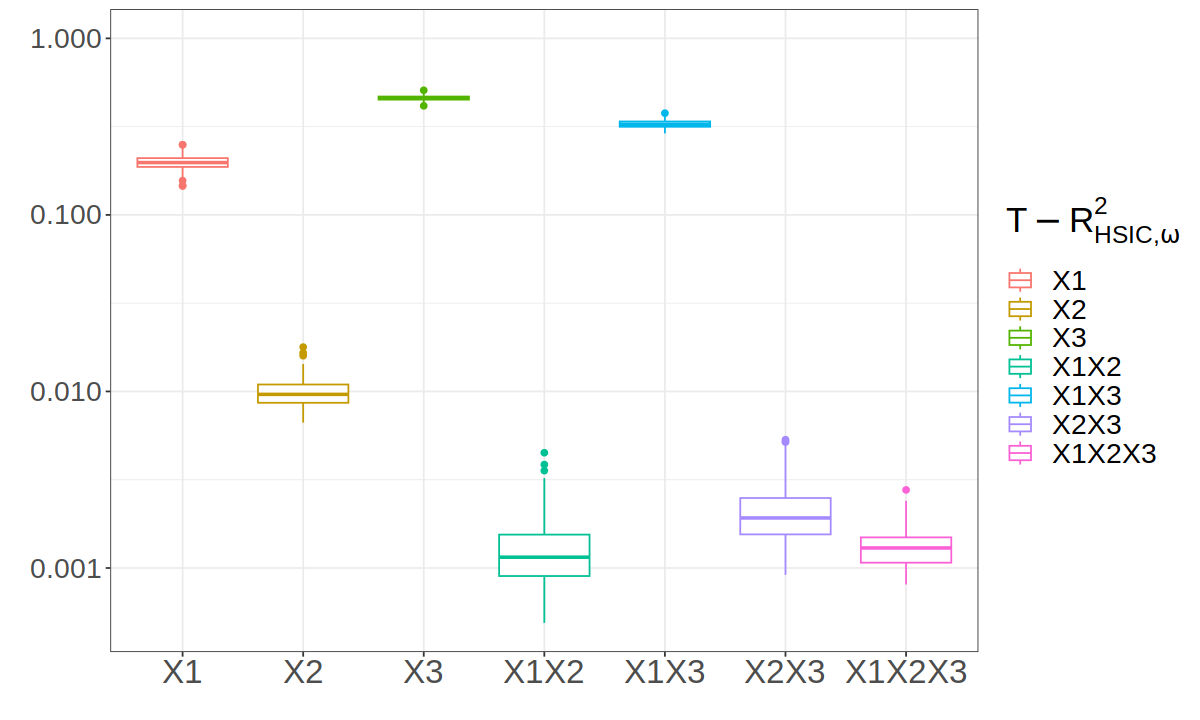

In [100]:
results = read.csv("results_hsic_ishigami_interactions.csv")
df_long <- pivot_longer(results, cols = everything(), names_to = "Variable", values_to = "Value")
df_long$Variable <- factor(df_long$Variable, levels = unique(df_long$Variable))

# Boxplots côte à côte
ggplot(df_long, aes(x = Variable, y = Value, col = Variable)) +
  geom_boxplot() +
  theme_bw() +
  labs(
    x = "", y = "",
    color = expression(T - R[phantom() * paste(plain("HSIC"), ",", omega)]^2)
  ) +
  scale_fill_brewer(palette = "Set2") +
  theme(
    legend.title = element_text(size = 21),
    legend.text  = element_text(size = 17),  
    axis.text.x  = element_text(size = 20), 
    axis.text.y  = element_text(size = 17) 
  ) + scale_y_log10() + coord_cartesian(ylim = c(NA, 1))